In [2]:
!pip install pulp


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.4 MB 8.5 MB/s eta 0:00:02
   ----------- ---------------------------- 4.7/16.4 MB 15.9 MB/s eta 0:00:01
   --------------- ------------------------ 6.6/16.4 MB 13.9 MB/s eta 0:00:01
   ------------------ --------------------- 7.6/16.4 MB 11.2 MB/s eta 0:00:01
   -------------------- ------------------- 8.4/16.4 MB 9.1 MB/s eta 0:00:01
   --------------------- ------------------ 8.9/16.4 MB 7.7 MB/s eta 0:00:01
   ---------------------- ----------------- 9.2/16.4 MB 6.9 MB/s eta 0:00:02
   ----------------------- ---------------- 9.4/16.4 MB 6.2 MB/s eta 0:00:02
   ----------------------- ---------------- 9.7/16.4 MB 5.5 MB/s eta 0:00:02
   ------------------------ --------------- 10.0/16.4 MB 4.8 MB/s eta 0:00:02
   ------------------------ --------------- 10.2/16.4 MB 4.5 MB/s eta 0:00:02


In [3]:
import numpy as np
import pandas as pd
import pulp

# -----------------------
# Parameters
# -----------------------
np.random.seed(42)

markets = ["USA", "Germany", "Japan", "India", "Brazil"]
demand_means = [2.5e6, 1.2e6, 1.0e6, 1.5e6, 1.0e6]
demand_stds  = [0.5e6, 0.2e6, 0.2e6, 0.3e6, 0.2e6]

fixed_costs_low = dict(zip(markets, [1e6, 0.8e6, 0.7e6, 0.6e6, 0.5e6]))
fixed_costs_high = dict(zip(markets, [1.5e6, 1.2e6, 1.1e6, 1.0e6, 0.9e6]))
capacity_low = 1e6
capacity_high = 3e6
var_cost = dict(zip(markets, [20, 18, 22, 15, 17]))  # $/unit

# Freight costs matrix (dummy values)
freight_costs = pd.DataFrame(
    [[0, 12, 15, 18, 16],
     [12, 0, 14, 17, 20],
     [15, 14, 0, 16, 19],
     [18, 17, 16, 0, 12],
     [16, 20, 19, 12, 0]],
    index=markets, columns=markets
)

short_penalty = 100
hold_penalty = 10

# -----------------------
# Monte Carlo Demand Scenarios
# -----------------------
n_scenarios = 50
demand_scenarios = {
    m: np.random.normal(mu, sigma, n_scenarios).clip(0, None)
    for m, mu, sigma in zip(markets, demand_means, demand_stds)
}

# -----------------------
# Deterministic LP (using mean demand)
# -----------------------
prob = pulp.LpProblem("SupplyChain", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("ship", (markets, markets), lowBound=0)
y_low = pulp.LpVariable.dicts("open_low", markets, cat="Binary")
y_high = pulp.LpVariable.dicts("open_high", markets, cat="Binary")

# Objective function (cost)
prob += (
    pulp.lpSum(fixed_costs_low[i]*y_low[i] + fixed_costs_high[i]*y_high[i] for i in markets)
    + pulp.lpSum(var_cost[i]*pulp.lpSum(x[i][j] for j in markets) for i in markets)
    + pulp.lpSum(freight_costs.loc[i,j]*x[i][j] for i in markets for j in markets)
)

# Capacity constraints
for i in markets:
    prob += pulp.lpSum(x[i][j] for j in markets) <= capacity_low*y_low[i] + capacity_high*y_high[i]

# Demand constraints (mean demand)
for j, mu in zip(markets, demand_means):
    prob += pulp.lpSum(x[i][j] for i in markets) >= mu

# Solve
prob.solve()
print("Deterministic Solution Status:", pulp.LpStatus[prob.status])
print("Objective Value (Cost):", pulp.value(prob.objective))
for i in markets:
    if y_low[i].value() > 0.5: print(f"Open Low in {i}")
    if y_high[i].value() > 0.5: print(f"Open High in {i}")


Deterministic Solution Status: Optimal
Objective Value (Cost): 138000000.0
Open High in USA
Open High in Germany
Open Low in Japan
Open High in India
Open Low in Brazil


In [5]:
# comparision
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import random
random.seed(1447)

In [6]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [7]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

In [8]:
## Data import 

In [30]:
# 1. production(includes service-intangible pdts too)/manufacturing  variable costs 
# all m are p , but not all p are m 
manvar_costs = pd.read_excel('data/variable costs.xlsx', index_col = 0)
manvar_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


In [31]:
# freight variable costs
freight_costs = pd.read_excel('data/freight costs.xlsx', index_col = 0)
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


In [15]:
# total variable costs (manufacturing variable +freight variable)
var_cost = freight_costs/1000 + manvar_costs 
var_cost

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


In [32]:
# factory fixed cost
fixed_costs = pd.read_excel('data/fixed cost.xlsx', index_col = 0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


In [33]:
# plants capacity - low and high
cap = pd.read_excel('data/capacity (1).xlsx', index_col = 0)
cap

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


In [34]:
# Demand (by Market)
demand = pd.read_excel('data/demand (1).xlsx', index_col = 0)
demand

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


In [55]:
# Define Decision Variables
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]
prod_name = [(i,j) for i in loc for j in loc]   

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)

# Create Decision Variables
x = LpVariable.dicts("production_", prod_name,
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_", 
                     plant_name, cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])      

# Solve Model
model.solve()
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,.2f} ($/Month)".format(pulp.value(model.objective)))


# Results Plant (Boolean)
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['Plant Opening'])
df_bool

C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Status: Optimal
Total Costs: 65,118,000.00 ($/Month)


,Plant Opening
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0
USA-HIGH,0.0
GERMANY-HIGH,0.0
JAPAN-HIGH,1.0
BRAZIL-HIGH,1.0
INDIA-HIGH,1.0


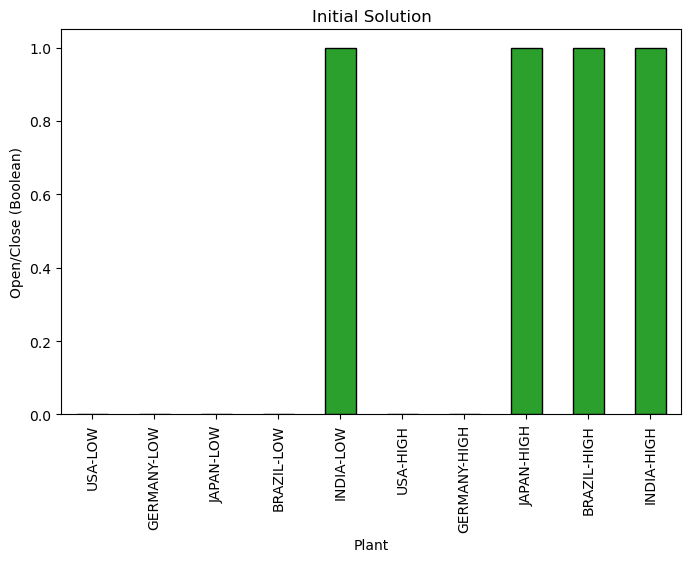

In [42]:
# Plant Opening graph
cap_plot = cap.copy()

ax = df_bool.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:green', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

In [26]:
##simulating several scenarios 

In [56]:
def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    '''Build the optimization based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]   

    # Initialize Class
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)

    # Create Decision Variables
    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')
    y = LpVariable.dicts("plant_", 
                         plant_name, cat='Binary')

    # Define Objective Function
    model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
              + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

    # Add Constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                           for s in size])                                                 
    # Solve Model
    model.solve()
    
    # Results
    status_out = LpStatus[model.status]
    objective_out  = pulp.value(model.objective)
    plant_bool = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    plant_prod = [x[prod_name[i]].varValue for i in range(len(prod_name))]
    return status_out, objective_out, y, x, fix, var

In [57]:
#normal distribution of demand
N = 50
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
# Demand 
CV = 0.5 (#coefficient of variation CV=σ/μ) (Using CV ensures that volatility is proportional to market size.#Big markets (mean = 1000) → bigger fluctuations (σ = 500).#Small markets (mean = 100) → smaller fluctuations (σ = 50).)
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t>=0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index = [0])

# Concat
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('data/df_demand-{}PC.xlsx'.format(int(CV * 100)))
    
df_demand.astype(int).head()

,scenario,USA,GERMANY,JAPAN,BRAZIL,INDIA
0,0,2800000,90000,1700000,145000,160000
0,1,1507473,132222,1170330,171728,140701
1,2,907641,66777,1227844,116482,188164
2,3,1433777,94325,1158220,147083,59876
3,4,4275098,69197,2710664,237687,275501


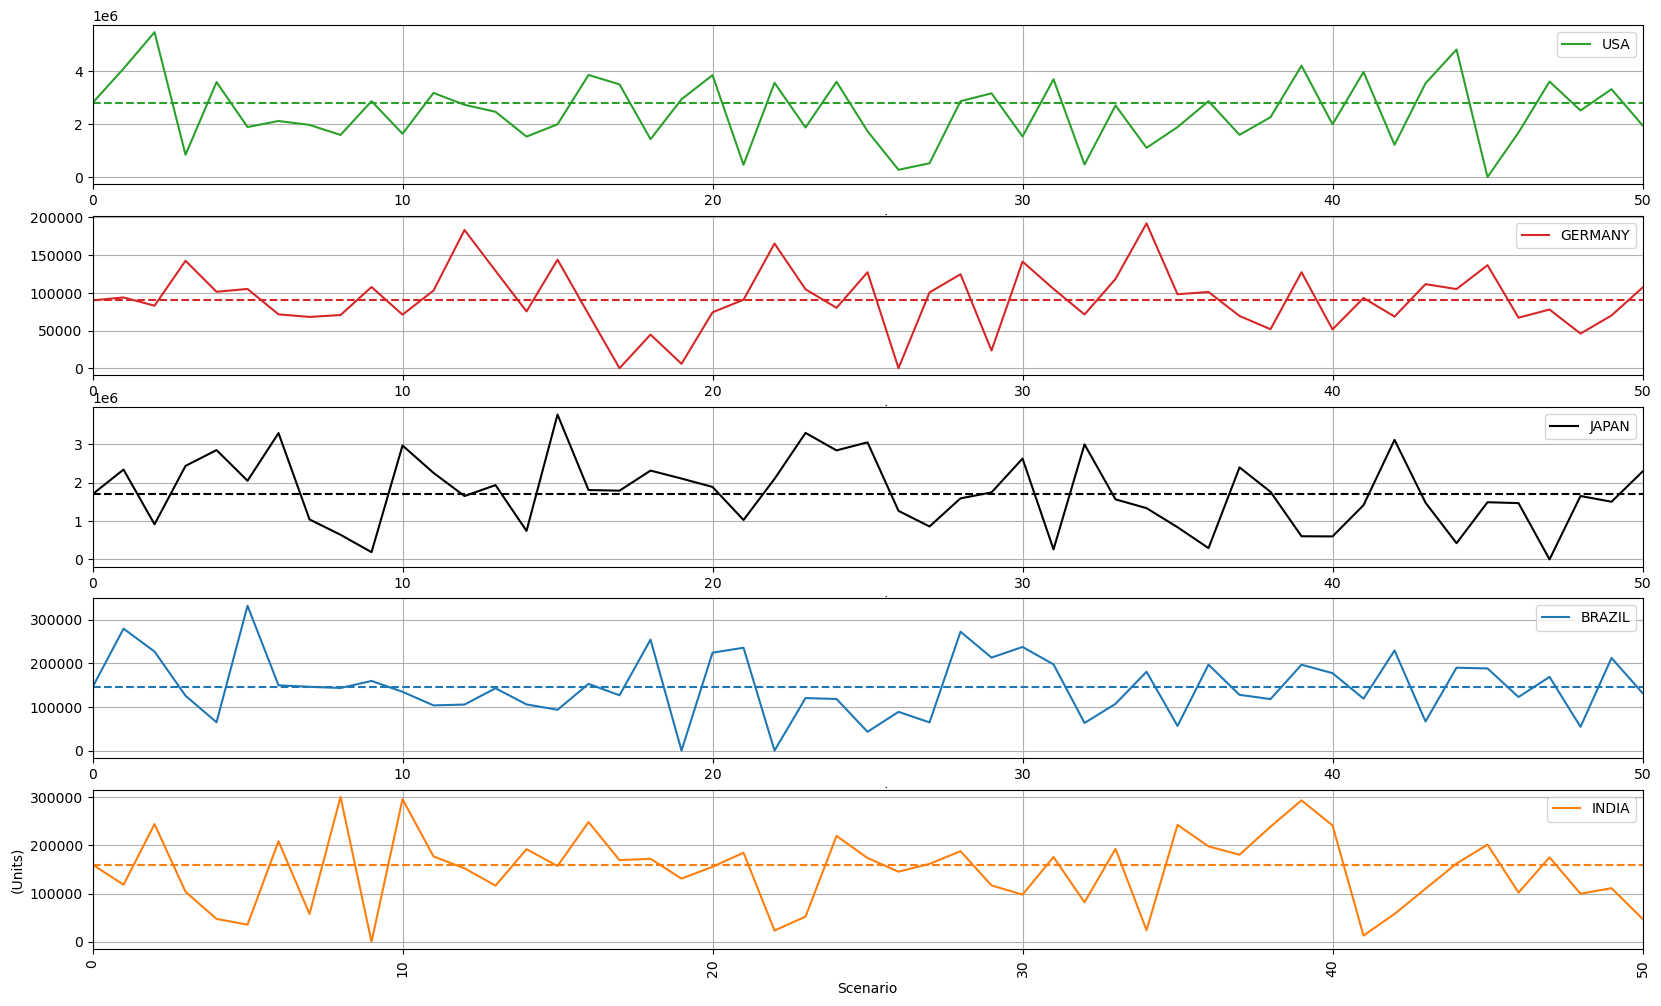

In [45]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(20, 12), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
plt.show()

In [47]:
# calculation : initial scenario
# Record results per scenario
list_scenario, list_status, list_results, list_totald, list_fixcost, list_varcost = [], [], [], [], [], []
# Initial Scenario
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand, 'Demand', cap)

# Add results
list_scenario.append('INITIAL')
total_demand = demand['Demand'].sum()
list_totald.append(total_demand)
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_varcost.append(var)
# Dataframe to record the solutions
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc], 
                        columns = ['INITIAL'])
df_bool.head()

C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,INITIAL
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0


In [48]:
# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario 
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, cap)    
    
    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
df_bool.to_excel('data/boolean-{}PC.xlsx'.format(int(CV * 100)))
# Other Results
df_bool.head()

C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packages\pulp\pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
C:\Users\Bura Samshritha\AppData\Roaming\Python\Python312\site-packa

,INITIAL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
USA-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
JAPAN-LOW,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRAZIL-LOW,0,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0
INDIA-LOW,1,1,1,1,0,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1


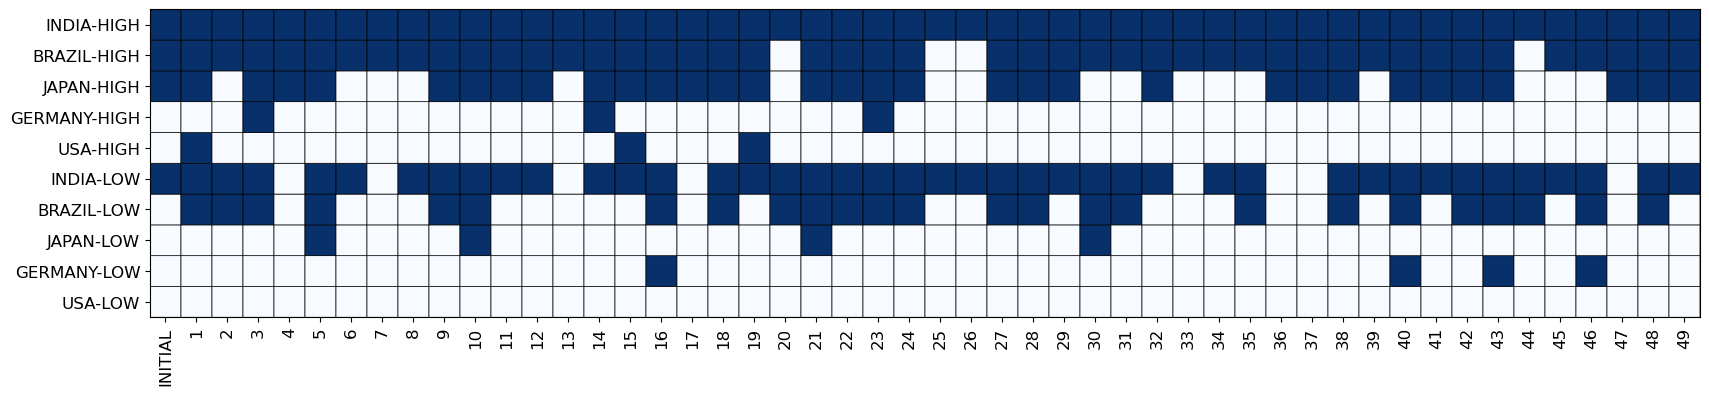

In [49]:
##FINAL PLOT
#BOOLEAN ALONE
# Plot the Grid
plt.figure(figsize = (20,4))
plt.pcolor( df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.show()

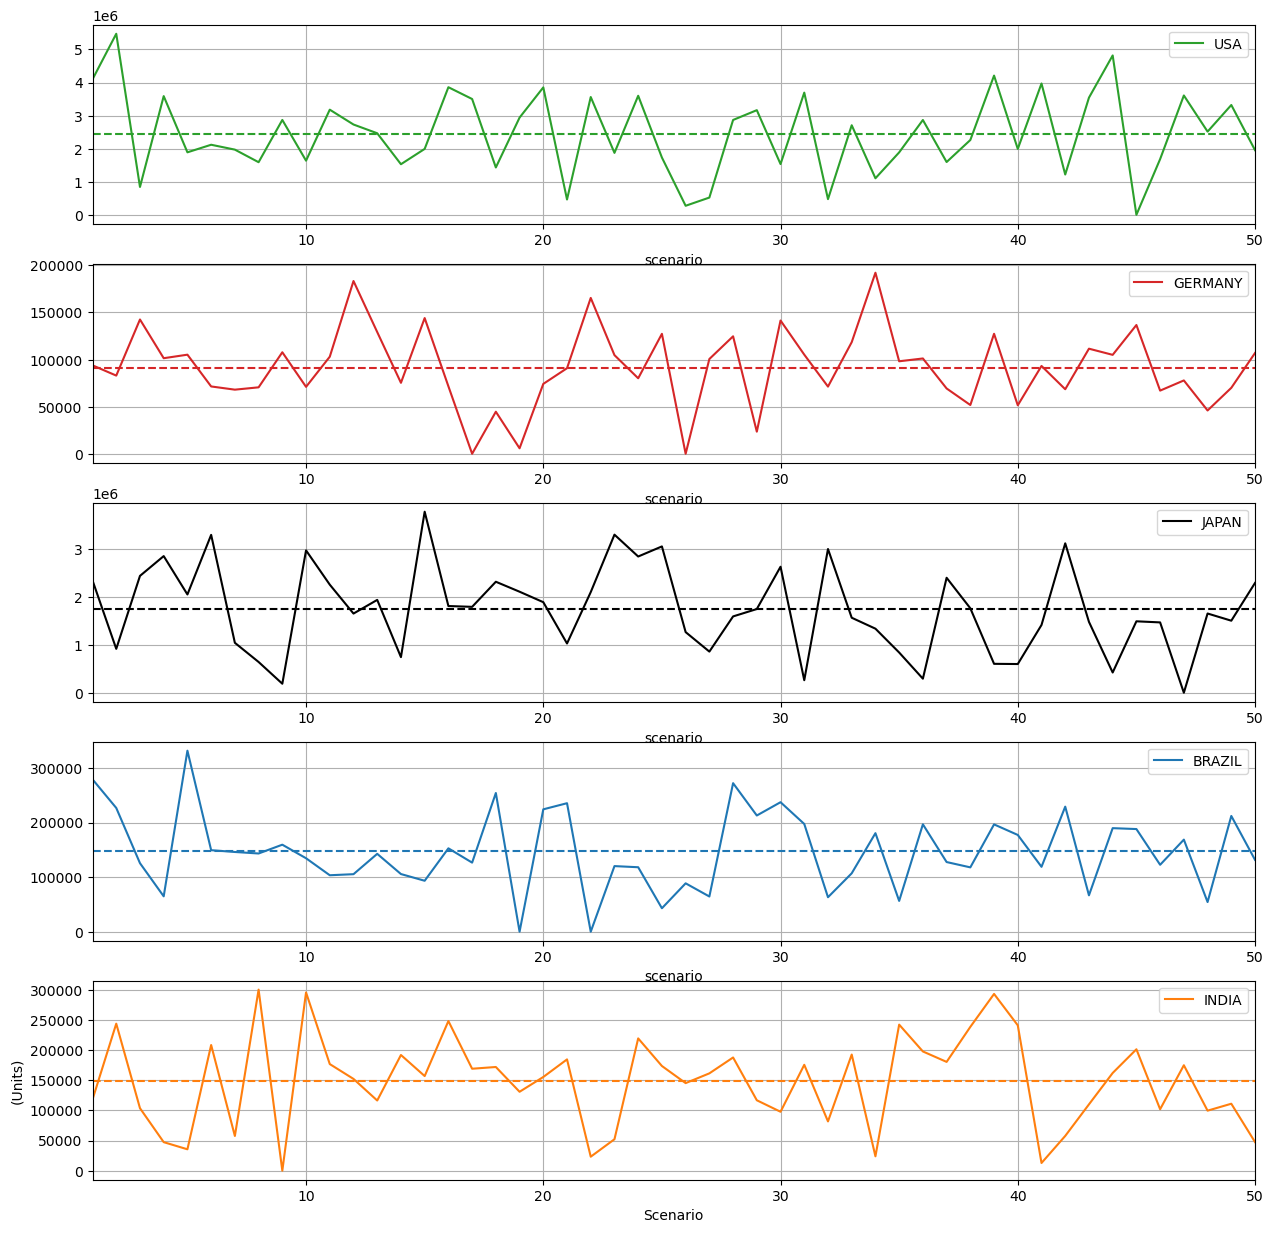

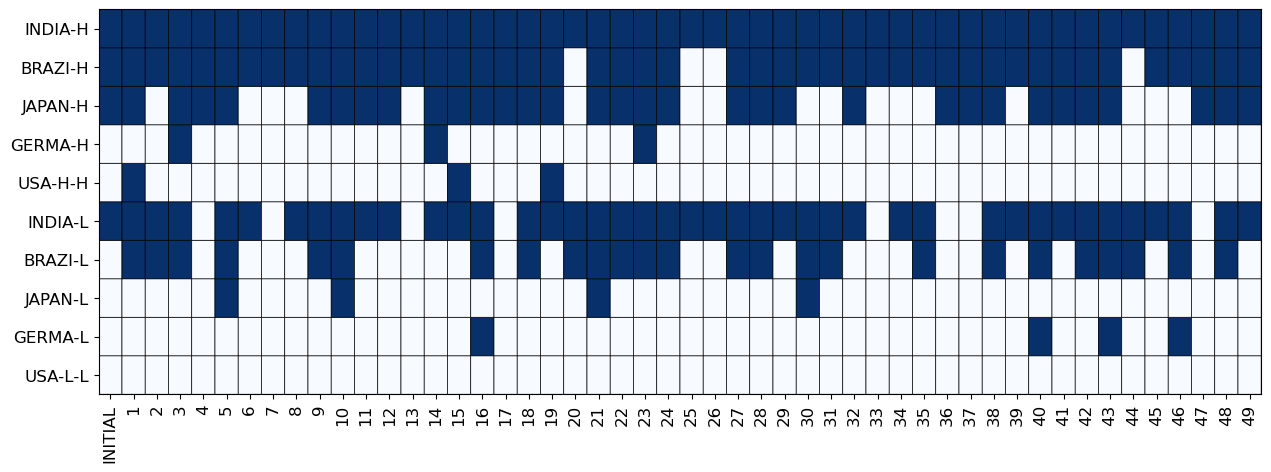

In [51]:
# ADDING DEMAND
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(15, 15), xlim=[1,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].mean(), color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')

# add the scenario plot
plt.figure(figsize=(15, 5))
plt.pcolor(df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], [d[0:5]+ '-H' * ('HIGH' in d) + '-L' * ('LOW' in d) for d in df_bool.index], fontsize=12)
plt.xticks(rotation=90)
plt.show()

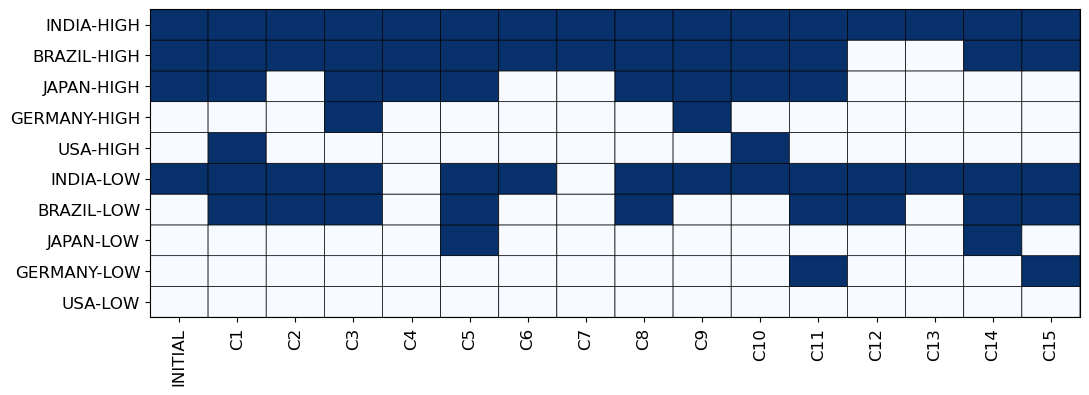

In [52]:
# FINDING OPTIMAL SOLUTION BY UNIQUE COMBINATIONS COUNT
# Unique combinations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
# Plot the Grid
plt.figure(figsize = (12,4))
plt.pcolor( df_unique, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.show()

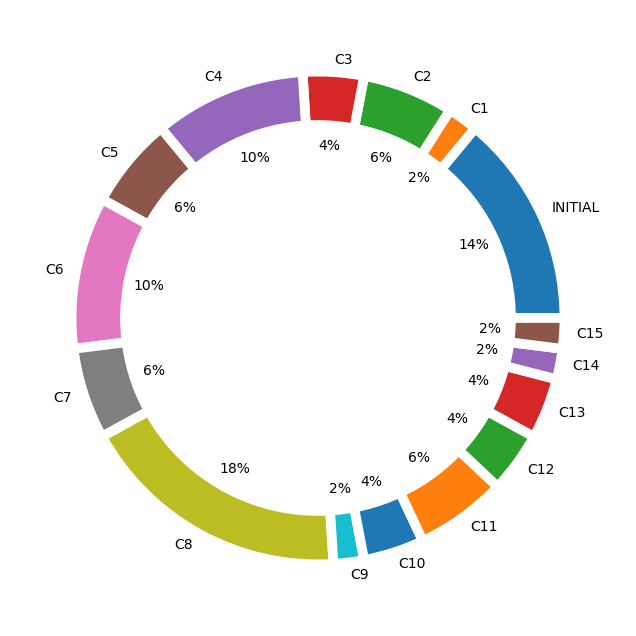

In [54]:

# Number of columns
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool.columns:
        if (df_bool[col2]!=df_unique[col1]).sum()==0:
            count += 1
    COL_NUMBER.append(count)
df_comb = pd.DataFrame({'column':COL_NAME, 'count':COL_NUMBER}).set_index('column')

my_circle = plt.Circle( (0,0), 0.8, color='white')
df_comb.plot.pie(figsize=(8, 8), x='column', y='count', legend= False, pctdistance=0.7,
                                          autopct='%1.0f%%', labeldistance=1.05, 
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
# plt.title('{:.2f} M€ Budget Applications in 9 Vertical Markets'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

%%HTML
<div style="font-size: 40px;">
    
**Quadratic Programming - Variable production costs depending on output levels**
</div>

In [1]:
!pip install docplex

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from docplex.mp.model import Model
import pandas as pd
import numpy as np